# 공통파일


In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import pandas as pd
import numpy as np
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_path_son = 'datathon_energy/'
file_path_hea = '' 

train = pd.read_csv(file_path_son+'train.csv', encoding='cp949')  # 파일 path 바꿔가면서 쓰시면 될 거 같아요
test = pd.read_csv(file_path_son+'test.csv', encoding='cp949')

#train = pd.read_csv('~/_Python/Exploration/data/energy/train.csv', encoding = "cp949")
#test = pd.read_csv('~/_Python/Exploration/data/energy/test.csv', encoding = "cp949")
train.columns = ['num', 'date', 'use_electric', 'temperature', 'wind_speed', 'humidity', 'precipitation', 'sunshine', 'operation', 'solar_power']
train['date']= pd.to_datetime(train['date'])


# 1. 데이터 분석

In [3]:
train.shape

(122400, 10)

In [4]:
train.head()

num                date  use_electric  temperature  wind_speed  humidity  \
0    1 2020-06-01 00:00:00      8179.056         17.6         2.5      92.0   
1    1 2020-06-01 01:00:00      8135.640         17.7         2.9      91.0   
2    1 2020-06-01 02:00:00      8107.128         17.5         3.2      91.0   
3    1 2020-06-01 03:00:00      8048.808         17.1         3.2      91.0   
4    1 2020-06-01 04:00:00      8043.624         17.0         3.3      92.0   

   precipitation  sunshine  operation  solar_power  
0            0.8       0.0        0.0          0.0  
1            0.3       0.0        0.0          0.0  
2            0.0       0.0        0.0          0.0  
3            0.0       0.0        0.0          0.0  
4            0.0       0.0        0.0          0.0

In [5]:
train.columns

Index(['num', 'date', 'use_electric', 'temperature', 'wind_speed', 'humidity',
       'precipitation', 'sunshine', 'operation', 'solar_power'],
      dtype='object')

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122400 entries, 0 to 122399
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   num            122400 non-null  int64         
 1   date           122400 non-null  datetime64[ns]
 2   use_electric   122400 non-null  float64       
 3   temperature    122400 non-null  float64       
 4   wind_speed     122400 non-null  float64       
 5   humidity       122400 non-null  float64       
 6   precipitation  122400 non-null  float64       
 7   sunshine       122400 non-null  float64       
 8   operation      122400 non-null  float64       
 9   solar_power    122400 non-null  float64       
dtypes: datetime64[ns](1), float64(8), int64(1)
memory usage: 9.3 MB


In [7]:
train.describe()

num   use_electric    temperature     wind_speed  \
count  122400.000000  122400.000000  122400.000000  122400.000000   
mean       30.500000    2324.830866      24.251713       2.151641   
std        17.318173    2058.999326       3.407902       1.514475   
min         1.000000       0.000000      11.100000       0.000000   
25%        15.750000    1055.268000      21.800000       1.100000   
50%        30.500000    1700.352000      24.200000       1.900000   
75%        45.250000    2780.487000      26.500000       2.900000   
max        60.000000   17739.225000      36.300000      20.100000   

            humidity  precipitation       sunshine      operation  \
count  122400.000000  122400.000000  122400.000000  122400.000000   
mean       80.169848       0.514989       0.213533       0.683333   
std        15.525862       2.624505       0.370517       0.465178   
min        19.000000       0.000000       0.000000       0.000000   
25%        70.000000       0.000000       0.000000       0.000000   
50%        84.000000       0.000000       0.000000       1.000000   
75%        93.000000       0.000000       0.300000       1.000000   
max       100.000000      81.500000       1.000000       1.000000   

         solar_power  
count  122400.000000  
mean        0.483333  
std         0.499724  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

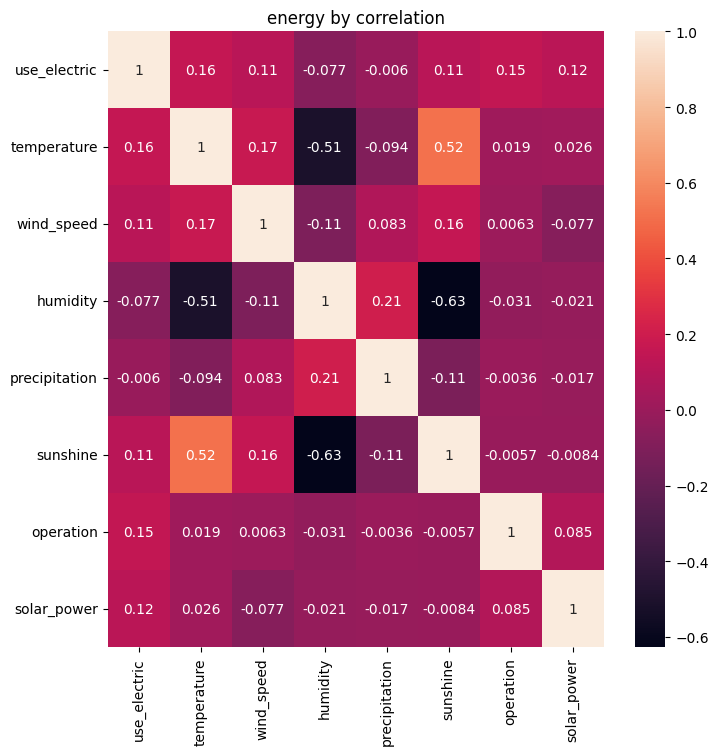

In [8]:
corr_df= train[['use_electric', 'date', 'temperature', 'wind_speed', 'humidity', 'precipitation', 'sunshine', 'operation', 'solar_power']]

# 한글 폰트 사용을 위해서 세팅
'''
from matplotlib import font_manager, rc
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
'''

plt.figure(figsize=(8,8))

sns.heatmap(data=corr_df.corr(), annot=True)
plt.title('energy by correlation')
plt.show()

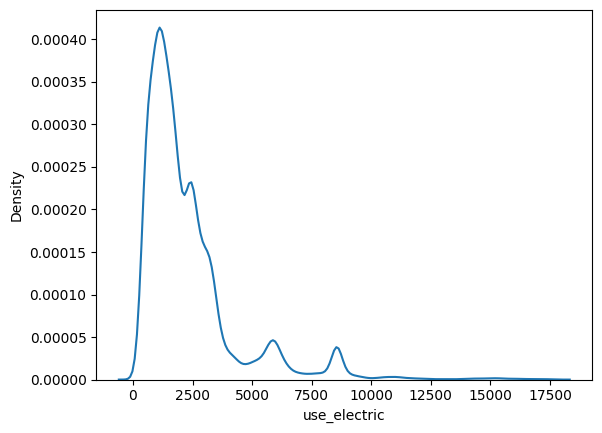

In [9]:
sns.kdeplot(data=train['use_electric'])
plt.show()

In [10]:
train['use_electric'].skew()  #왜도 : 분포가 대칭을 벗어나 치우친 정도

2.569979214229397

In [11]:
train['use_electric'].kurt()  # 첨도 : 뽀족한 정도

8.998589167827355

## feature 별 전력사용량과의 관계

In [12]:
# CATE_COLS = ['num', "mgrp", 'holiday', 'dow', 'cluster', 'hot', 'nelec_cool_flag', 'solar_flag']
# for col in CATE_COLS:
#     df[col] = df[col].astype(str).astype('category')





In [13]:
train.head()

num                date  use_electric  temperature  wind_speed  humidity  \
0    1 2020-06-01 00:00:00      8179.056         17.6         2.5      92.0   
1    1 2020-06-01 01:00:00      8135.640         17.7         2.9      91.0   
2    1 2020-06-01 02:00:00      8107.128         17.5         3.2      91.0   
3    1 2020-06-01 03:00:00      8048.808         17.1         3.2      91.0   
4    1 2020-06-01 04:00:00      8043.624         17.0         3.3      92.0   

   precipitation  sunshine  operation  solar_power  
0            0.8       0.0        0.0          0.0  
1            0.3       0.0        0.0          0.0  
2            0.0       0.0        0.0          0.0  
3            0.0       0.0        0.0          0.0  
4            0.0       0.0        0.0          0.0

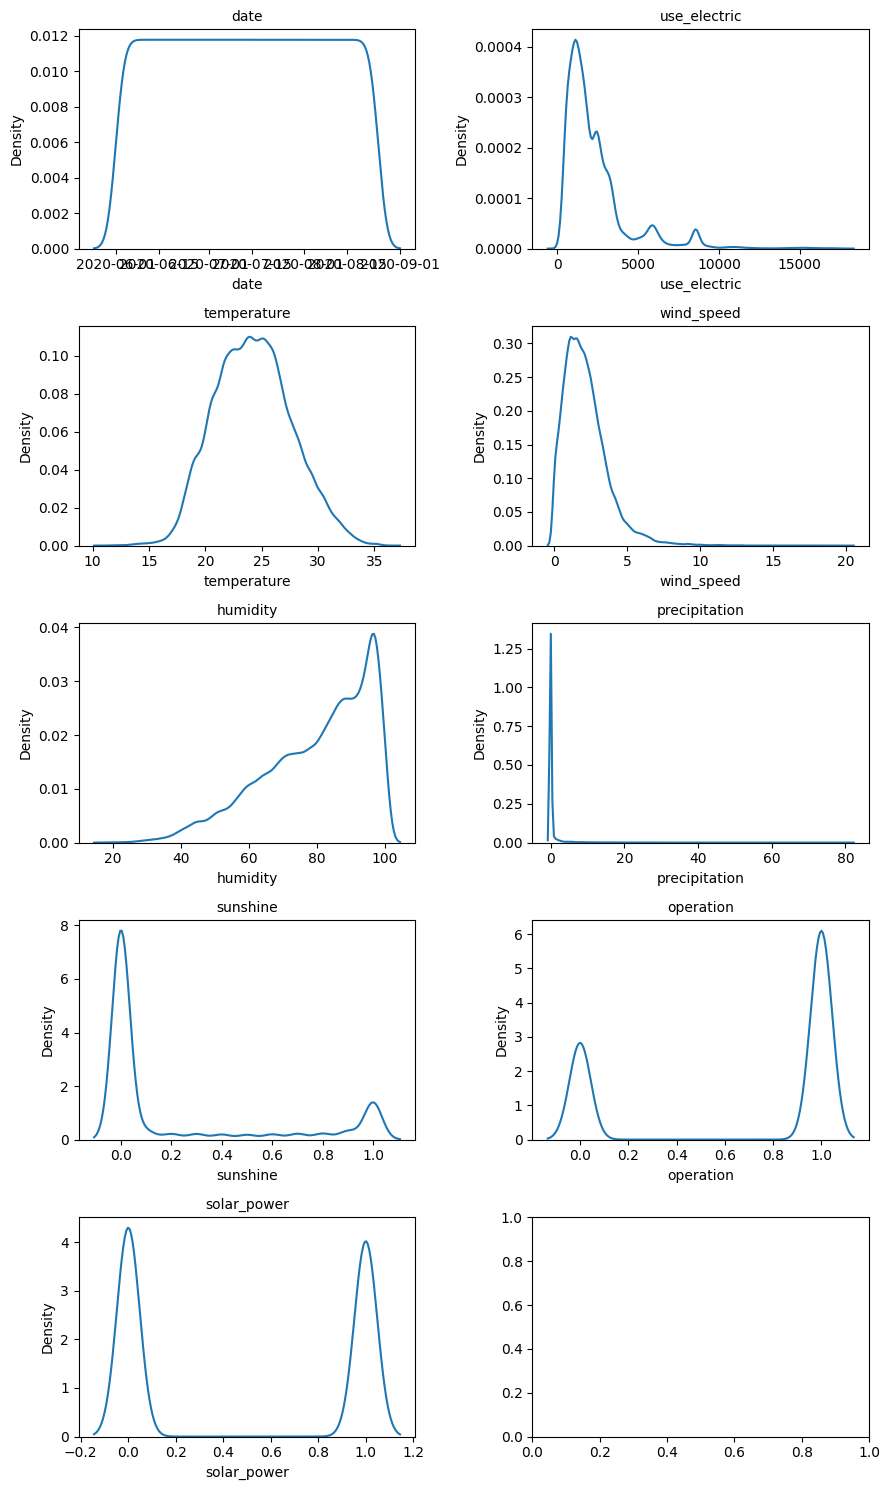

In [14]:
skew_columns = ['date', 'use_electric', 'temperature', 'wind_speed', 'humidity', 'precipitation', 'sunshine', 'operation', 'solar_power']

fig, ax = plt.subplots(5, 2, figsize=(9, 15), tight_layout=True)

count = 0
for row in range(5):
    for col in range(2):
        if count == 9:
            break
        sns.kdeplot(data=train[skew_columns[count]], ax=ax[row][col] )
        ax[row][col].set_title(skew_columns[count], fontsize=10)
        count += 1

In [15]:
## 개별 컬럼 분석

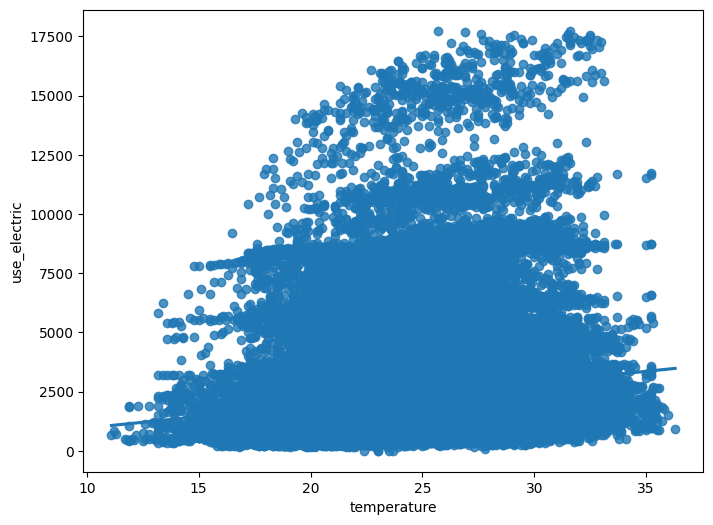

In [16]:
#'date', 'use_electric', 'temperature', 'wind_speed', 'humidity', 'precipitation', 'sunshine', 'operation', 'solar_power'

data = pd.concat([train['use_electric'], train['temperature']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='temperature', y="use_electric", data=data)

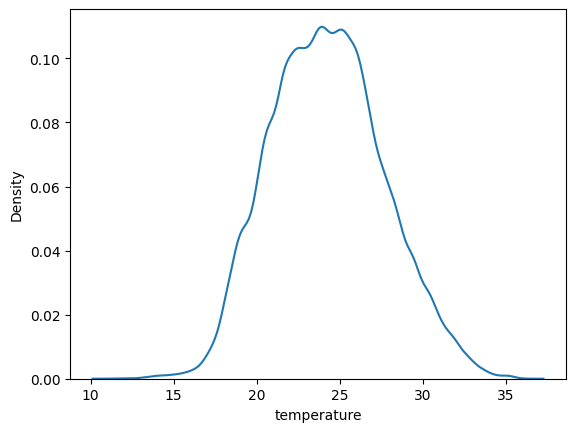

In [17]:
kde = sns.kdeplot(train['temperature'])

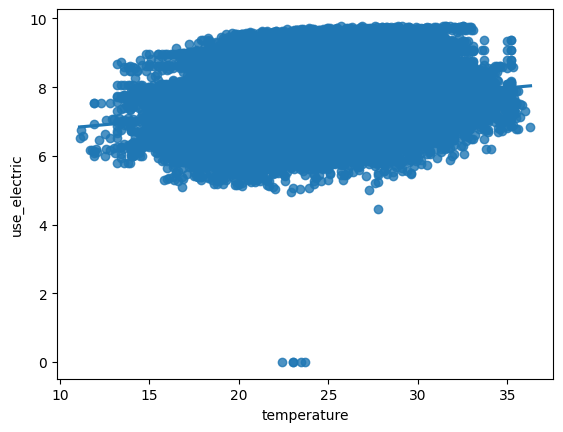

In [18]:
x,y = train['temperature'], np.log1p(train['use_electric'])   # 시계열 데이터라서 상관도로 보기에는 힘듬.

fig = sns.regplot(x=x,y=y)

In [19]:
# 시간 변수

date = train['date']
train['hour'] = date.dt.hour
train['day'] = date.dt.weekday
train['month'] = date.dt.month
train['week'] = date.dt.weekofyear # 1년 중 몇번째 주
train['dayofyear'] = date.dt.dayofyear  # 1년 중 몇번째 날

In [20]:
train['week'].unique()

array([23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35], dtype=int64)

In [21]:
# 공휴일 변수 추가

train['holiday'] = train.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
train['holiday'].unique()

array([0, 1], dtype=int64)

In [22]:
# 공휴일 변수 추가

train['holiday'] = train.apply(lambda x : 0 if x['day']<5 else 1, axis = 1)
train.loc[('2020-08-17'<=train['date'])&(train['date']<'2020-08-18'), 'holiday'] = 1

In [23]:
# 시간을 sin, cos 함수로

train['sin_time'] = np.sin(2*np.pi*train.hour/24)
train['cos_time'] = np.cos(2*np.pi*train.hour/24)

In [24]:
# THI(temperature-humidity index) : 불쾌지수

train['THI'] = 9/5*train['temperature'] - 0.55*(1-train['humidity']/100)*(9/5*train['humidity']-26)+32

In [25]:
# CDH(Cooling Degree Hour) : 냉방 도일

def CDH(xs):
    ys = []
    for i in range(len(xs)):
        if i < 11:
            ys.append(np.sum(xs[:(i+1)]-26))
        else:
            ys.append(np.sum(xs[(i-11):(i+1)]-26))
    return np.array(ys)

cdhs = np.array([])
for num in range(1,61,1):
    temp = train[train['num'] == num]
    cdh = CDH(temp['temperature'].values)
    cdhs = np.concatenate([cdhs, cdh])
train['CDH'] = cdhs

In [26]:
# 체감 온도

train['body_temperature'] = 13.12 + 0.6215*train['temperature'] - 11.37*(train['wind_speed']*3.6)**0.16 + 0.3965*(train['wind_speed']*3.6)**0.16*train['temperature']

In [27]:
# 화씨로 변형

train['temperature_F'] = (train['temperature'] * 9/5) + 32 

# 열지수

T = train['temperature_F']
RH = train['humidity']
train['heat_index'] = -42.379 + 2.04901523*T + 10.14333127*RH - .22475541*T*RH - .00683783*T*T - .05481717*RH*RH + .00122874*T*T*RH + .00085282*T*RH*RH - .00000199*T*T*RH*RH
train['heat_index'] = (train['heat_index']-32) * 5/9
train.loc[train['heat_index']<32, 'heat_index'] = 0
train.loc[(train['heat_index']>=32) & (train['heat_index']<41), 'heat_index'] = 1
train.loc[(train['heat_index']>=41) & (train['heat_index']<54), 'heat_index'] = 2
train.loc[(train['heat_index']>=54) & (train['heat_index']<66), 'heat_index'] = 3
train.loc[train['heat_index']>=66, 'heat_index'] = 4

In [38]:
train['month_day'] = train['date'].astype(str).str[:10] ## 2020-06-01
train['echo_type'] = train['operation'] + train['solar_power']*2 ##  0: 아무것도 없음 1: operation만 2:solar_system만 3: operation과 solar_system 둘다

In [28]:
train.columns

Index(['num', 'date', 'use_electric', 'temperature', 'wind_speed', 'humidity',
       'precipitation', 'sunshine', 'operation', 'solar_power', 'hour', 'day',
       'month', 'week', 'dayofyear', 'holiday', 'sin_time', 'cos_time', 'THI',
       'CDH', 'body_temperature', 'temperature_F', 'heat_index'],
      dtype='object')

In [39]:
train.head()

num                date  use_electric  temperature  wind_speed  humidity  \
0    1 2020-06-01 00:00:00      8179.056         17.6         2.5      92.0   
1    1 2020-06-01 01:00:00      8135.640         17.7         2.9      91.0   
2    1 2020-06-01 02:00:00      8107.128         17.5         3.2      91.0   
3    1 2020-06-01 03:00:00      8048.808         17.1         3.2      91.0   
4    1 2020-06-01 04:00:00      8043.624         17.0         3.3      92.0   

   precipitation  sunshine  operation  solar_power  ...  holiday  sin_time  \
0            0.8       0.0        0.0          0.0  ...        0  0.000000   
1            0.3       0.0        0.0          0.0  ...        0  0.258819   
2            0.0       0.0        0.0          0.0  ...        0  0.500000   
3            0.0       0.0        0.0          0.0  ...        0  0.707107   
4            0.0       0.0        0.0          0.0  ...        0  0.866025   

   cos_time      THI   CDH  body_temperature  temperature_F  heat_index  \
0  1.000000  57.5376  -8.4         17.816719          63.68         0.0   
1  0.965926  57.0389 -16.7         17.786580          63.86         0.0   
2  0.866025  56.6789 -25.2         17.444480          63.50         0.0   
3  0.707107  55.9589 -34.1         16.961384          62.78         0.0   
4  0.500000  56.4576 -43.1         16.806826          62.60         0.0   

    month_day  echo_type  
0  2020-06-01        0.0  
1  2020-06-01        0.0  
2  2020-06-01        0.0  
3  2020-06-01        0.0  
4  2020-06-01        0.0  

[5 rows x 25 columns]

In [40]:
def draw3D(df, x, y, z, coloraxis = None):
    import plotly.graph_objs as go
    import numpy as np

    # Create some random data
    n = 100
    # Define the color map
    #colorscale = [[0, 'blue'], [1./3, 'green'], [2./3, 'red'], [1, 'blue']]
    colorscale = ['#000000', '#6b0707', '#ec8109', '#ecc509', '#76ec09', '#09a8ec']

    if (coloraxis == None):
        coloraxis = z
    # Create the scatter plot with z-axis colored
    fig = go.Figure(data=[go.Scatter3d(
        x=df[x],
        y=df[y],
        z=df[z],
        mode='markers',
        marker=dict(
            size=2,
            color=df[coloraxis],
            colorscale=colorscale,
            opacity=0.8,
            colorbar=dict(
                title='Z Axis Colorbar Title'
            )
        ),
        hovertemplate='x: %{x}<br>y: %{y}<br>z: %{z}<br>color: %{marker.color}<extra></extra>'
    )])

    # Add axis labels
    fig.update_layout(width=1000, height=800, scene=dict(xaxis_title=x, yaxis_title=y, zaxis_title=z))

    # Show the plot
    fig.show()

In [42]:
#표준편차 구하기
df_std=train['use_electric'].groupby([train['num'], train['month_day'],train['echo_type']]).std()
df_std=df_std.reset_index()
df_std['ele_std']=df_std['use_electric']
df_std.drop('use_electric', axis =1 ,inplace=True)
_type =[3,32,18,39]
display = df_std[df_std['num'].isin(_type)==True]
draw3D(display,'num','month_day','ele_std','echo_type')

In [41]:
#1. -자형데이타
_type =[1,9,18,19,21,31,32,33,36,39]
display = train[train['num'].isin(_type)==True]
draw3D(display,'num','month_day','use_electric','echo_type')

In [30]:
train.corr()

num  use_electric  temperature  wind_speed  \
num               1.000000e+00     -0.063193     0.000363   -0.052184   
use_electric     -6.319335e-02      1.000000     0.158361    0.109965   
temperature       3.631250e-04      0.158361     1.000000    0.167455   
wind_speed       -5.218413e-02      0.109965     0.167455    1.000000   
humidity          5.378530e-03     -0.077199    -0.509105   -0.110439   
precipitation    -4.673261e-03     -0.006028    -0.093788    0.083433   
sunshine         -1.368529e-02      0.112131     0.515657    0.156381   
operation         6.103135e-02      0.150799     0.019067    0.006275   
solar_power       9.918068e-02      0.116344     0.025865   -0.076560   
hour             -1.864340e-15      0.091472     0.299772    0.154075   
day              -5.496906e-15     -0.053759     0.038934   -0.015742   
month            -1.903384e-14      0.052146     0.387839    0.049345   
week             -2.176205e-14      0.060549     0.397067    0.036280   
dayofyear        -7.365699e-14      0.056091     0.399972    0.034961   
holiday           2.361091e-15     -0.071508     0.072283   -0.020347   
sin_time          5.350831e-19     -0.100212    -0.389857   -0.207026   
cos_time          8.547108e-18     -0.195080    -0.367655   -0.185748   
THI               1.213259e-02      0.089470     0.560367    0.065033   
CDH               4.154501e-04      0.041269     0.667055    0.031380   
body_temperature  8.421804e-03      0.145723     0.985736    0.074512   
temperature_F     3.631250e-04      0.158361     1.000000    0.167455   
heat_index       -2.247866e-02      0.093187     0.552098    0.114513   

                  humidity  precipitation  sunshine     operation  \
num               0.005379      -0.004673 -0.013685  6.103135e-02   
use_electric     -0.077199      -0.006028  0.112131  1.507991e-01   
temperature      -0.509105      -0.093788  0.515657  1.906651e-02   
wind_speed       -0.110439       0.083433  0.156381  6.274912e-03   
humidity          1.000000       0.208862 -0.627597 -3.140481e-02   
precipitation     0.208862       1.000000 -0.112646 -3.559549e-03   
sunshine         -0.627597      -0.112646  1.000000 -5.694932e-03   
operation        -0.031405      -0.003560 -0.005695  1.000000e+00   
solar_power      -0.020657      -0.016685 -0.008412  8.484178e-02   
hour             -0.260312      -0.022181  0.161754  6.172320e-16   
day               0.014376      -0.016890  0.005472  3.985792e-16   
month             0.319072       0.083960 -0.127870  2.163714e-16   
week              0.339502       0.086421 -0.134317 -3.890250e-15   
dayofyear         0.340433       0.084971 -0.133770 -6.021126e-15   
holiday          -0.024221      -0.011990  0.035288  3.615573e-17   
sin_time          0.340833       0.036206 -0.202176 -6.432029e-19   
cos_time          0.317803      -0.005170 -0.492559  2.599008e-18   
THI               0.325783       0.155578  0.006842 -9.674416e-03   
CDH              -0.143657      -0.039229  0.007814  2.273829e-02   
body_temperature -0.492487      -0.107031  0.506081  1.486297e-02   
temperature_F    -0.509105      -0.093788  0.515657  1.906651e-02   
heat_index       -0.203578      -0.061485  0.314021  4.558601e-03   

                   solar_power          hour  ...          week     dayofyear  \
num               9.918068e-02 -1.864340e-15  ... -2.176205e-14 -7.365699e-14   
use_electric      1.163441e-01  9.147217e-02  ...  6.054924e-02  5.609129e-02   
temperature       2.586485e-02  2.997718e-01  ...  3.970669e-01  3.999718e-01   
wind_speed       -7.655996e-02  1.540747e-01  ...  3.628025e-02  3.496125e-02   
humidity         -2.065729e-02 -2.603125e-01  ...  3.395022e-01  3.404332e-01   
precipitation    -1.668520e-02 -2.218069e-02  ...  8.642093e-02  8.497088e-02   
sunshine         -8.412045e-03  1.617544e-01  ... -1.343174e-01 -1.337696e-01   
operation         8.484178e-02  6.172320e-16  ... -3.890250e-15 -6.021126e-15   
solar_power       1.000000e+00

## 데이터들의 경향, 주기, 계절성, 불규칙성을 파악 (시계열데이터 정상성 확인)

저희가 배웠던 관점으로 확인해보고 insight를 얻을 수도 있을 것 같아요

시계열 데이터의 계절성을 테스트하는 방법
일반적인 방법은 고정된 시간 구간에서 반복적인 패턴을 체크하고 계열 데이터를 도표화하는 것이다. 계절성의 타입은 달력이나 시계로 정의된다.
1. 하루 중 시간 마다 반복
2. 월 중 일 마다 반복
3. 주 마다 반복
4. 월 마다 반복
5. 연 마다 반복

자료
https://post.naver.com/viewer/postView.nhn?volumeNo=28094462

In [31]:
from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 13, 6    # matlab 차트의 기본 크기를 13, 6으로 지정

use_electric=train['use_electric']
use_electric.index=train['date']
use_electric

date
2020-06-01 00:00:00    8179.056
2020-06-01 01:00:00    8135.640
2020-06-01 02:00:00    8107.128
2020-06-01 03:00:00    8048.808
2020-06-01 04:00:00    8043.624
                         ...   
2020-08-24 19:00:00    4114.368
2020-08-24 20:00:00    3975.696
2020-08-24 21:00:00    3572.208
2020-08-24 22:00:00    3299.184
2020-08-24 23:00:00    3204.576
Name: use_electric, Length: 122400, dtype: float64

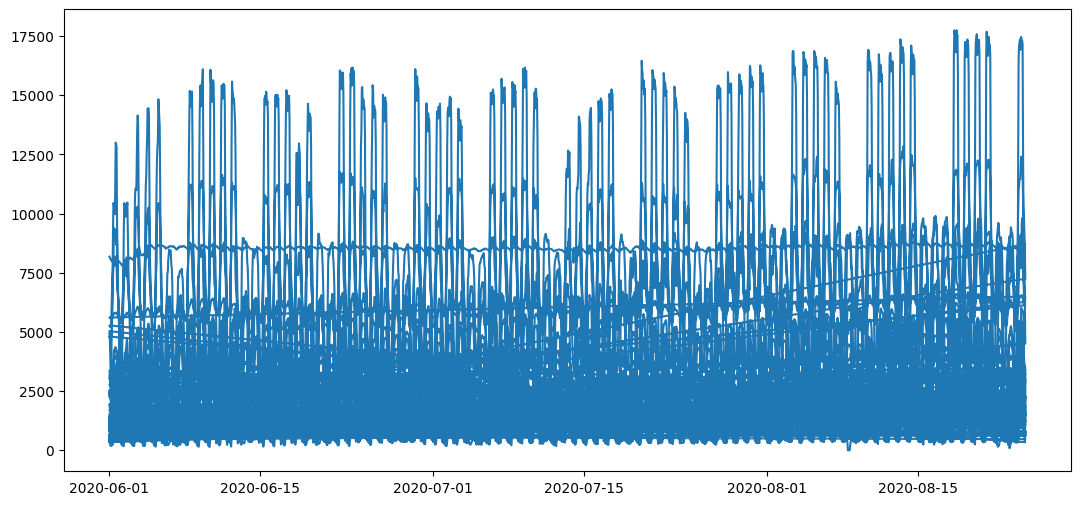

In [32]:
plt.plot(use_electric)  # 그래프가 너무 더러워서... 이건 다른 시각화 방법 써보는 게 좋을 것 같습니다 ㅎ..

In [33]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

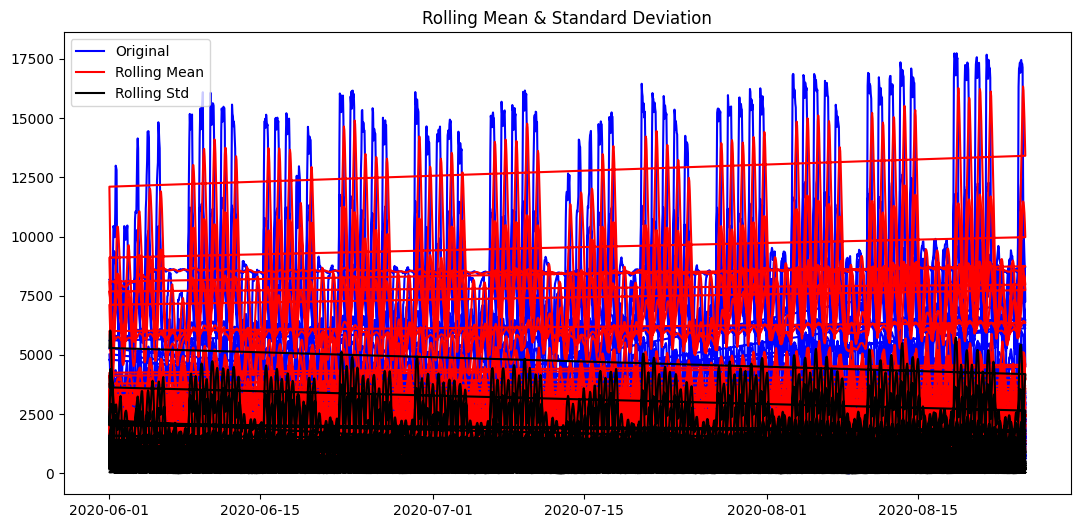

In [34]:
plot_rolling_statistics(use_electric, window=12)

대체적으로 안정적이긴 한데 중간에 빨간선이 왜 그어졌는지는 모르겠음

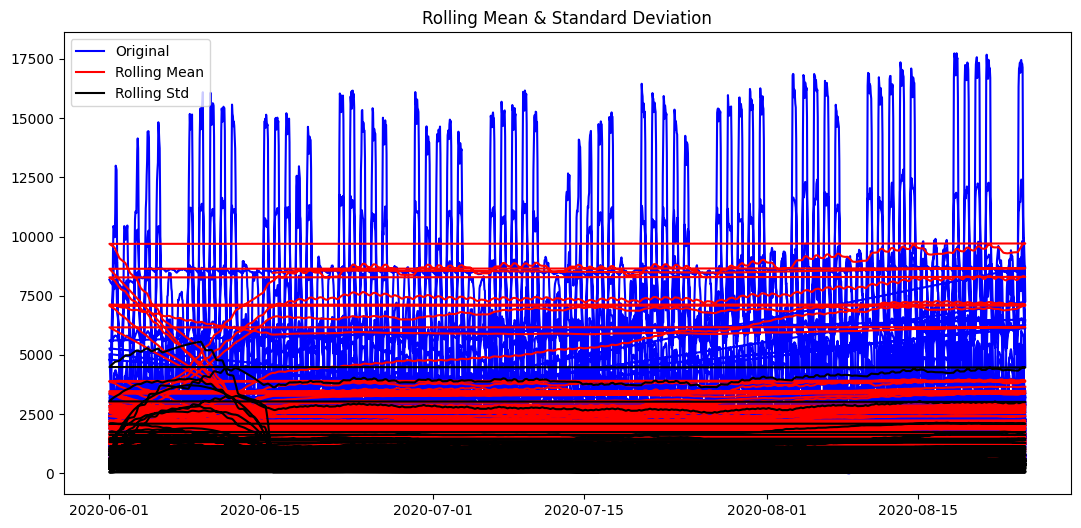

In [35]:
plot_rolling_statistics(use_electric, window=365)  # 이건 mean 값이 중구난방 ㅋㅋ

In [36]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [37]:
augmented_dickey_fuller_test(use_electric)

Results of Dickey-Fuller Test:
Test Statistic                -6.759891e+00
p-value                        2.809658e-09
#Lags Used                     7.100000e+01
Number of Observations Used    1.223280e+05
Critical Value (1%)           -3.430403e+00
Critical Value (5%)           -2.861564e+00
Critical Value (10%)          -2.566783e+00
dtype: float64


p-value가 거의 0에 가까워서 귀무가설은 기각될 수 있음

따라서 안정적인 데이터라고 볼 수 있음. 하지만 윗 그래프를 보면 이동 평균값과 이동 표준편차 선이 좀 일그러져서 이상치나 또 다른 확인이 필요할 것 같아요 예를 들어 군집화..ㅎ.ㅎ

업종별(1)     2020    2020.1    2020.2    2020.3    2020.4    2020.5  \
0     업종별(1)  업체수 (개)  합계 (toe)  연료 (toe)  연료 (toe)  연료 (toe)  연료 (toe)   
1     업종별(1)       소계        소계        소계       석탄류       석유류       가스류   
2          계     1320   2823334    838577         -     66285    772292   
3         상용      157    295480     54125         -      2763     51362   
4         공공       61    200895     48235         -      5085     43150   
5        아파트      438    570667    192663         -     18574    174089   
6         호텔       66    204495    109151         -      5833    103317   
7         병원       98    334423    158010         -      2017    155993   
8         학교      104    287358     96314         -      4924     91389   
9   IDC(전화국)       47    193569      2035         -       403      1632   
10       연구소       69    258518     78075         -     15312     62764   
11       백화점      142    235989     44930         -       998     43932   
12      건물기타      138    241940     55038         -     10376     44663   

      2020.6     2021    2021.1    2021.2    2021.3    2021.4    2021.5  \
0   전력 (MWh)  업체수 (개)  합계 (toe)  연료 (toe)  연료 (toe)  연료 (toe)  연료 (toe)   
1         소계       소계        소계        소계       석탄류       석유류       가스류   
2   23078575     1367   2947581    849212         -     56542    792671   
3    2806455      156    291682     55762         -      3052     52710   
4    1775113       59    165784     35703         -      5076     30627   
5    4395391      466    599152    179650         -     15703    163947   
6    1108660       71    225400    120362         -      5136    115227   
7    2051314      100    354358    166842         -      2037    164805   
8    2221452      106    303235    101266         -      3781     97485   
9    2227131       50    231893      2034         -       377      1657   
10   2098170       72    264925     75165         -     10389     64776   
11   2221614      145    248072     50178         -      1068     49111   
12   2173276      142    263080     62249         -      9924     52325   

      2021.6  
0   전력 (MWh)  
1         소계  
2   24399639  
3    2743254  
4    1512572  
5    4877934  
6    1221364  
7    2180410  
8    2348484  
9    2672775  
10   2206508  
11   2301089  
12   2335250

# 2.모델링 전략 수립

# 3. 전처리

# 4. Normalization

# 5.모델링

# 6.하이퍼 파라미터 

# 7.훈련 및 예측 Blending

# 8. 파일 출력 및 제출

# 9.회고